In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def display_image(image, vmax):
    # Display the image
    plt.imshow(image, cmap='gray', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.axis('off')
    # Show the plot
    plt.show()

In [3]:
def histogram_equalization(image):
    # Calculate the histogram
    histogram, _ = np.histogram(image.flatten(), bins=2**16, range=[0, 2**16-1])
    
    # Calculate the cumulative distribution function (CDF)
    cdf = histogram.cumsum()
    
    # Normalize the CDF
    cdf_normalized = cdf / float(cdf.max())
    
    # Map the input image values to the equalized values
    equalized_image = np.interp(image.flatten(), np.arange(2**16), cdf_normalized * (2**16-1))
    
    # Reshape the equalized image to its original shape
    equalized_image = equalized_image.reshape(image.shape)
    
    # Convert the image data back to 16-bit integer type
    equalized_image = equalized_image.astype(np.uint16)
    
    return equalized_image


In [4]:
def construct_image_cube(folder_name, a, b, c, d):
    folder_path = f'../data/{folder_name}'
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    image_files = sorted(image_files)

    # Create an empty array to store the multispectral image cube
    image_cube = np.empty((12, ), dtype=object)

    # Loop through the image files and read the first 12 images
    count = 0
    for image_file in image_files:
        sequential_number = int(image_file.split('_')[-2])
        if 1 <= sequential_number <= 12:
            image_path = os.path.join(folder_path, image_file)
            #print(image_path)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            # Crop the fragment region
            image = image[a:c, b:d]
            image_cube[count] = image
            count += 1
            if count == 12:
                break

    # Stack the images in the image cube along the first dimension
    image_cube = np.stack(image_cube, axis=0)

    return image_cube


In [5]:
# Define the folders
folders = ['124-001', '124-002', '198-001', '198-003', '198-006', '690-001']

# Define the a, b, c, d values
a, b, c, d = 1690, 2390, 3990, 5460

# Read the image cubes for each folder and store them in separate variables
image_cube_124_001 = construct_image_cube('124-001', a, b, c, d)
image_cube_124_002 = construct_image_cube('124-002', 1300, 1500, 4500, 6000)
image_cube_198_001 = construct_image_cube('198-001', 1300, 50, 4500, 6000)
image_cube_198_003 = construct_image_cube('198-003', a, b, c, d)
image_cube_198_006 = construct_image_cube('198-006', a, b, c, d)
image_cube_690_001 = construct_image_cube('690-001', a, b, c, 4500)


In [6]:
def save_color_image(image_cube, folder_name):

    # Load the individual band images
    blue_band = image_cube[1]
    green_band = image_cube[3]
    red_band = image_cube[5]

    # Create an empty RGB image
    bgr_image = np.zeros((red_band.shape[0], red_band.shape[1], 3), dtype=np.uint16)

    # Assign the bands to the corresponding channels
    bgr_image[:, :, 0] = blue_band
    bgr_image[:, :, 1] = green_band
    bgr_image[:, :, 2] = red_band

    # Save the color image as a 16 bit .tif file in the output folder
    output_path = os.path.join('outputs', f'{folder_name}_rgb_image.tif')
    cv2.imwrite(output_path, bgr_image)

    return


In [7]:
save_color_image(image_cube_124_001, '124-001')
save_color_image(image_cube_124_002, '124-002')
save_color_image(image_cube_198_001, '198-001')
save_color_image(image_cube_198_003, '198-003')
save_color_image(image_cube_198_006, '198-006')
save_color_image(image_cube_690_001, '690-001')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


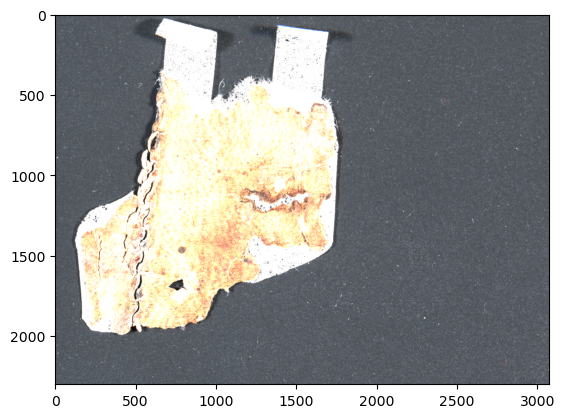

In [8]:
# Read an rgb 16bit image
bgr_image = cv2.imread('outputs/198-006_rgb_image.tif', cv2.IMREAD_UNCHANGED)
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image)
plt.show()

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import cv2

def cluster(clustering_type, number_clusters, m, n, features, feature_type):
    num_bands = features.shape[1]

    vectors = features.reshape(-1, num_bands)

    if clustering_type == 'kmeans':
        # Perform K-means clustering
        clustering_model = KMeans(n_clusters=number_clusters, random_state=42)
    elif clustering_type == 'gaussian':
        # Perform Gaussian Mixture clustering
        clustering_model = GaussianMixture(n_components=number_clusters, random_state=42)
    else:
        raise ValueError("Invalid clustering type. Expected 'kmeans' or 'gaussian'.")

    clusters = clustering_model.fit_predict(vectors)

    # Define a set of contrastive colors
    contrastive_colors = [(255, 0, 0),    # Red
                          (0, 255, 0),    # Green
                          (0, 0, 255),    # Blue
                          (255, 255, 0),  # Yellow
                          (255, 0, 255),  # Magenta
                          (0, 255, 255),  # Cyan
                          (255, 128, 0),  # Orange
                          (153, 0, 153)]  # Murdum

    # Select colors based on the number of clusters
    cluster_colors = np.array(contrastive_colors[:number_clusters], dtype=np.uint8)

    # Count the number of pixels in each cluster
    pixel_counts = [np.sum(clusters == cluster_label) for cluster_label in np.unique(clusters)]

    # Create a colored image based on the cluster assignments
    colored_image = cluster_colors[clusters].reshape(m, n, -1)

    # Define color names corresponding to each cluster label
    color_names = {
        0: "Red",
        1: "Green",
        2: "Blue",
        3: "Yellow",
        4: "Magenta",
        5: "Cyan",
        6: "Orange",
        7: "Murdum"
    }

    # Print labels, corresponding color names, and number of pixels
    for cluster_label in np.unique(clusters):
        color_name = color_names[cluster_label]
        num_pixels = pixel_counts[cluster_label]
        print(f"Cluster {cluster_label} is assigned the color {color_name} with {num_pixels} pixels")
    
    # Save the image with cluster information
    image_name = f"outputs/{feature_type}_features_{clustering_type}_clusters_{number_clusters}.png"   
    plt.imshow(colored_image)
    plt.show()
    
    rgb_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(image_name, rgb_image)
    
    return colored_image


In [10]:
def extract_den6(image_cube):
    m, n = image_cube.shape[1], image_cube.shape[2]
    features = np.zeros((m * n, 6), dtype=np.float32)

    for i in range(m):
        for j in range(n):
            pixel_values = image_cube[:, i, j]

            if pixel_values[0] > 300:
                pixel_values[11] = 110             
            
            f1 = pixel_values[3] - pixel_values[2]
            f2 = pixel_values[11] - pixel_values[0]
            f3 = pixel_values[10] - pixel_values[9]
            f4 = pixel_values[4] - pixel_values[0]  
            f5 = pixel_values[11]
            f6 = pixel_values[10]

            features[i * n + j] = [f1, f2, f3, f4,f5,f6]

    return features

In [11]:
def extract_hole(image_cube):
    m, n = image_cube.shape[1], image_cube.shape[2]
    special_features = np.zeros((m * n, 4), dtype=np.float32)

    for i in range(m):
        for j in range(n):
            pixel_values = image_cube[:, i, j]

            
            f1 = (pixel_values[11] - pixel_values[5]) / 5

            f2 = 1 if pixel_values[11] > 100 else 0  # Add the feature if the value at band 12 is bigger than 100
            
            f3 = np.sum(pixel_values[:4] < 80)  # Count of values less than 80 in the first 4 bands
            
            f4 = pixel_values[11] - pixel_values[0]  # Difference between band 12 and band 1


            special_features[i * n + j] = [f1, f2, f3, f4]

    return special_features


In [12]:
def extract_objects_by_color(color_codes, segmented_image):
    binary_image = np.zeros(segmented_image.shape[:2], dtype=np.uint8)

    for color_code in color_codes:
        color_mask = np.all(segmented_image == color_code, axis=2)
        binary_image[color_mask] = 255

    return binary_image

In [15]:
den6 = extract_den6(image_cube_124_001)


Cluster 0 is assigned the color Red with 3982337 pixels
Cluster 1 is assigned the color Green with 379675 pixels
Cluster 2 is assigned the color Blue with 2698988 pixels


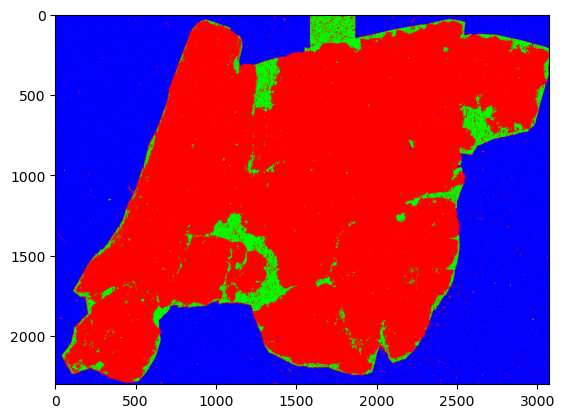

In [26]:
segmented_image_2 = cluster('gaussian', 3, image_cube_124_001.shape[1], image_cube_124_001.shape[2], den6, 'den6')

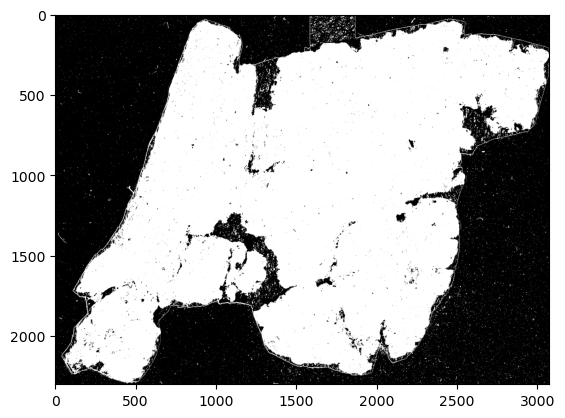

In [85]:
color_codes = [(255, 0, 0)]
parchment_ink_rice = extract_objects_by_color(color_codes, segmented_image_2)
plt.imshow(parchment_ink_rice, cmap='gray')

In [86]:
import cv2
import numpy as np

# Load the binary image
binary_image = parchment_ink_rice

# Find the connected components in the binary image, excluding the edges
_, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Set a threshold for the minimum component size (adjust the value as needed)
min_component_size = 100

# Create a mask to filter out small connected components
mask = np.zeros_like(binary_image, dtype=np.uint8)
for label, stat in enumerate(stats[1:], start=1):
    if stat[4] >= min_component_size:
        mask[labels == label] = 255

# Close the small black holes on the white regions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Apply the closed mask to the original binary image
parchment_ink = cv2.bitwise_and(binary_image, closed_mask)



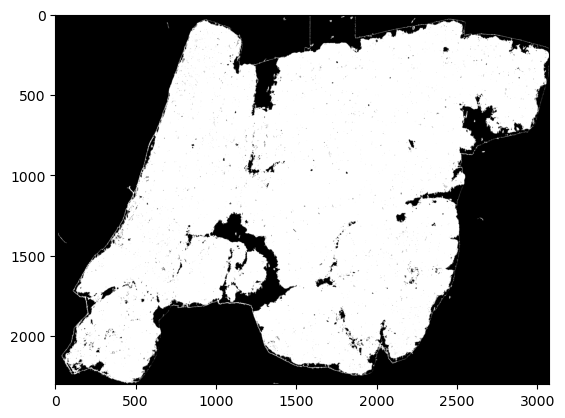

In [87]:
plt.imshow(parchment_ink, cmap='gray')

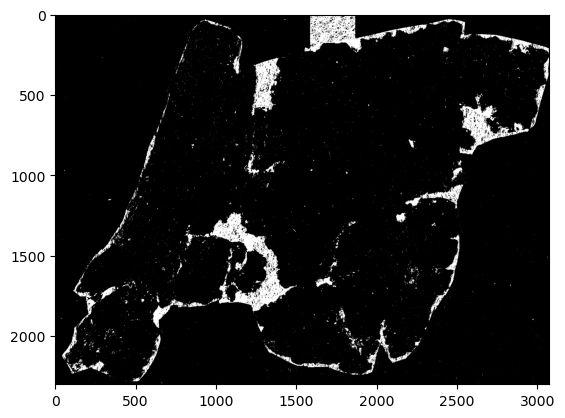

In [88]:
color_codes = [(0, 255, 0)]
rice = extract_objects_by_color(color_codes, segmented_image_2)
plt.imshow(rice, cmap='gray')

Cluster 0 is assigned the color Red with 1111432 pixels
Cluster 1 is assigned the color Green with 2606020 pixels
Cluster 2 is assigned the color Blue with 2368111 pixels
Cluster 3 is assigned the color Yellow with 595578 pixels
Cluster 4 is assigned the color Magenta with 379859 pixels


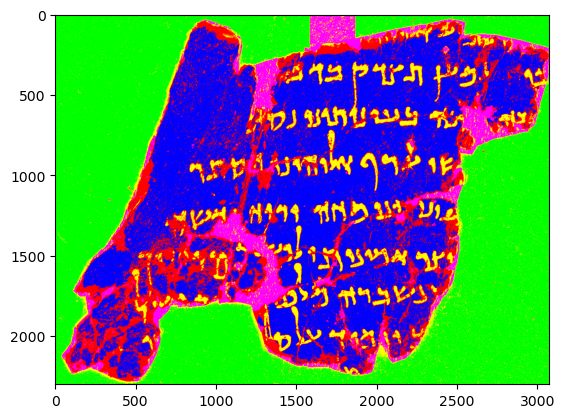

In [17]:
segmented_image = cluster('gaussian', 5, image_cube_124_001.shape[1], image_cube_124_001.shape[2], den6, 'den6')

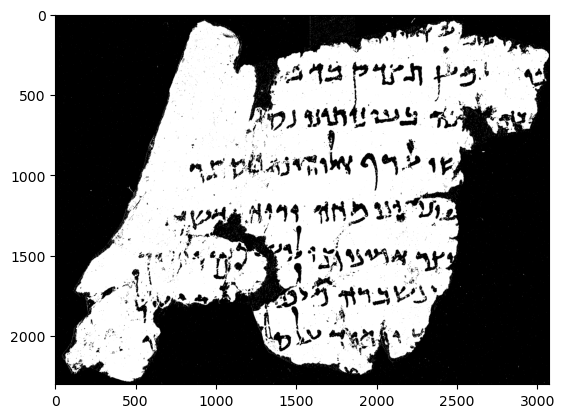

In [91]:
color_codes = [(255, 0, 0), (0, 0, 255)]
parchment = extract_objects_by_color(color_codes, segmented_image)
plt.imshow(parchment, cmap='gray')

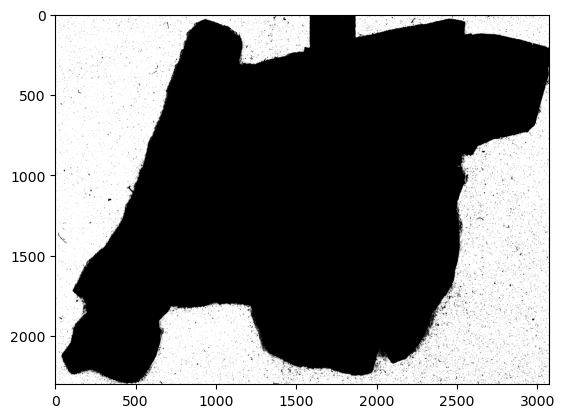

In [90]:
color_codes = [(0, 255, 0)]
back = extract_objects_by_color(color_codes, segmented_image)
plt.imshow(back, cmap='gray')

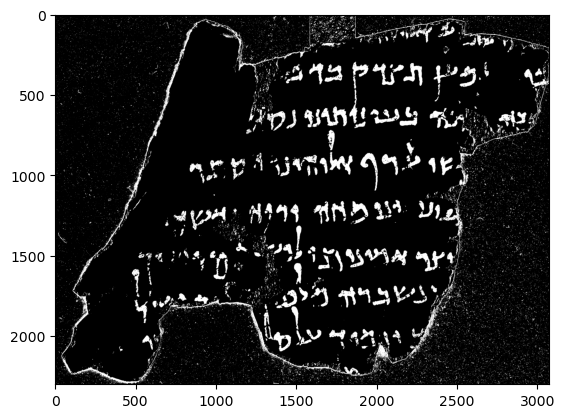

In [89]:
color_codes = [(255, 255, 0)]
ink_rice = extract_objects_by_color(color_codes, segmented_image)
plt.imshow(ink_rice, cmap='gray')

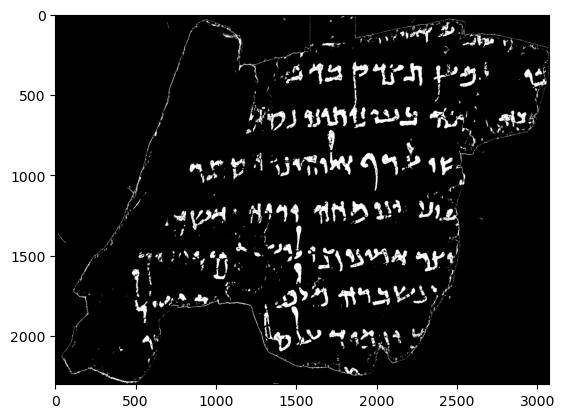

In [92]:
ink = cv2.bitwise_and(ink_rice, parchment_ink)
plt.imshow(ink, cmap='gray')

Cluster 0 is assigned the color Red with 6407740 pixels
Cluster 1 is assigned the color Green with 653260 pixels


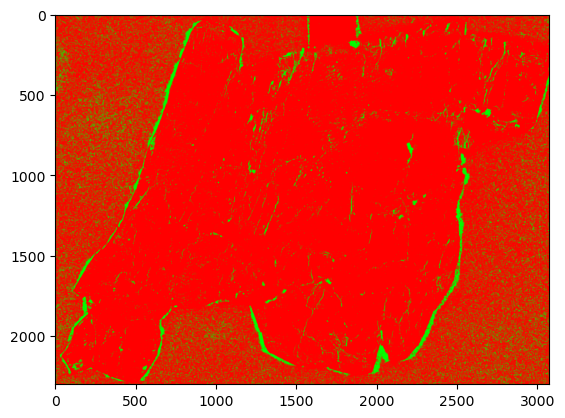

In [94]:
hole_features = extract_hole(image_cube_124_001)
hole_image = cluster('gaussian', 2, image_cube_124_001.shape[1], image_cube_124_001.shape[2], hole_features, 'hole')

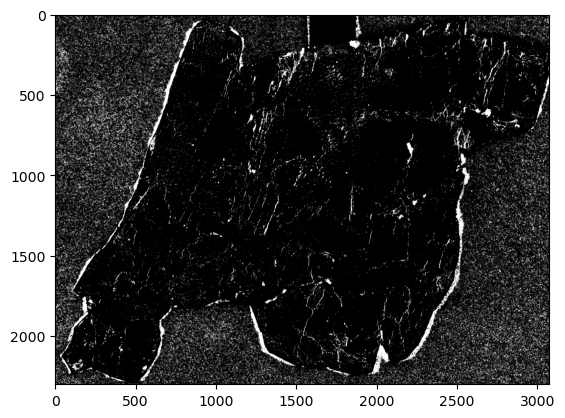

In [96]:
color_codes = [(0, 255, 0)]
hole = extract_objects_by_color(color_codes, hole_image)
plt.imshow(hole, cmap='gray')

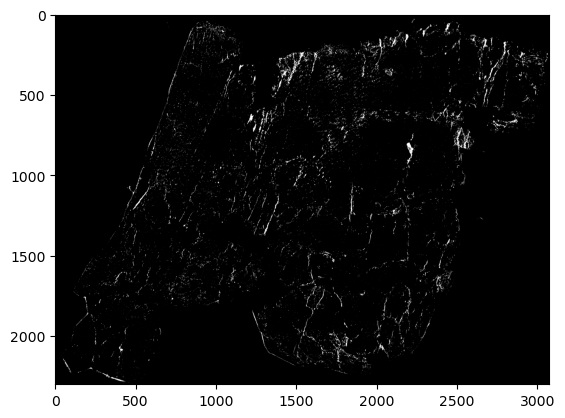

In [98]:
hole_on_parchment = cv2.bitwise_and(parchment_ink, hole)
plt.imshow(hole_on_parchment, cmap='gray')

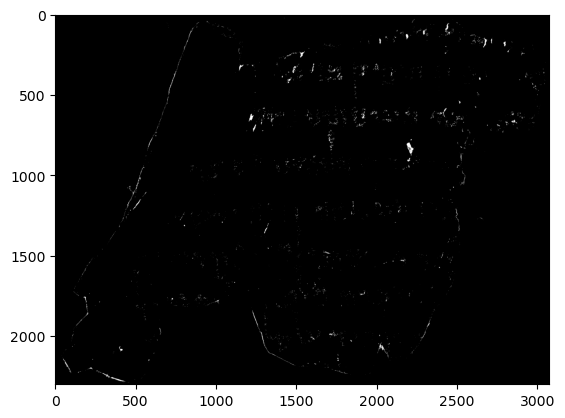

In [99]:
sole = cv2.bitwise_and(ink, hole_on_parchment)
plt.imshow(sole, cmap='gray')

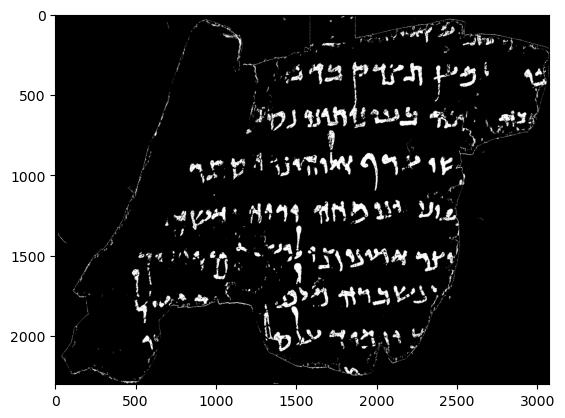

In [100]:
ink_pure = cv2.bitwise_xor(sole, ink)
plt.imshow(ink_pure, cmap='gray')